In [1]:
import sys

sys.path.append('../')

In [2]:
import numpy as np
import graphviz
from IPython.display import display
from environments.tree.tree import NaryTreeEnvironment
from environments.tree.data import TrajectoryDataset

In [3]:
set(np.arange(23)) - set(np.arange(11))

{11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

Node path from 12 to 6: [12, 5, 2, 6]
[0, 0, 2]
Action path from 12 to 6: [(12, 0), (5, 0), (2, 2), (6, 3)]


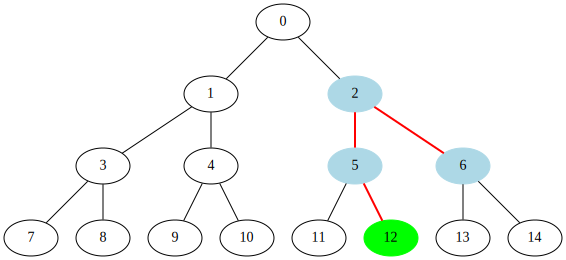

After action 0:


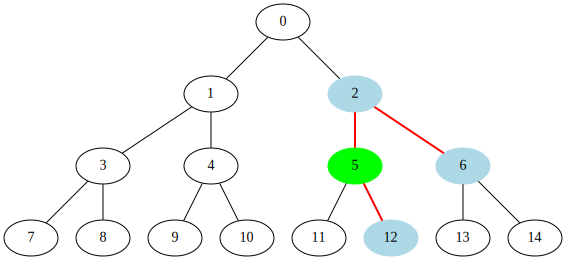

After action 0:


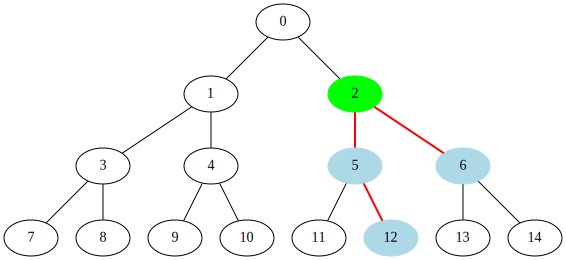

After action 2:


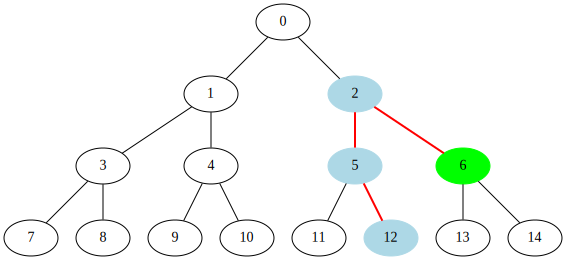

In [4]:
env = NaryTreeEnvironment(depth=4, branching_factor=2)

# Choose two nodes
start_node = 12
end_node = 6

# Get the node path
node_path = env.get_node_path(start_node, end_node)
print(f"Node path from {start_node} to {end_node}: {node_path}")

# Get the action path
action_path = env.get_action_path(start_node, end_node)
actions = [x[1] for x in action_path][:-1]
print(actions)

print(f"Action path from {start_node} to {end_node}: {action_path}")

# Display the tree with highlighted path
env.agent_position = start_node
env.display(highlight_path=node_path)

for action in actions:
    env.move_agent(action)
    print(f"After action {action}:")
    env.display(highlight_path=node_path)


In [5]:
ds = TrajectoryDataset(4, 2, 10)

gamma: 0.1


In [24]:
anchor = ds[0][0]

torch.tensor(anchor)

[(8, 0), (3, 0), (1, 0), (0, 2), (2, 1), (5, 3)]
[4, 6, 7, 9, 10, 11, 12, 13, 14]


tensor([1, 0])

In [21]:
import torch

torch.arange(3)

tensor([0, 1, 2])

In [51]:
state = int(anchor[0])

a = torch.full((3,1), state)

In [52]:
exclude_index = 2

v = torch.cat([
        torch.arange(0, exclude_index),
        torch.arange(exclude_index + 1, env.branching_factor + 2)
    ])

In [56]:
torch.cat([a , v.unsqueeze(-1)], dim=-1)

tensor([[1, 0],
        [1, 1],
        [1, 3]])

In [58]:
import torch
import torch.nn as nn

class CategoricalMLP(nn.Module):
    def __init__(self, cat_features, embedding_dims, hidden_dims, output_dim):
        super(CategoricalMLP, self).__init__()
        
        # Embedding layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) 
            for num_categories, emb_dim in zip(cat_features, embedding_dims)
        ])
        
        # Calculate total embedding dimension
        total_emb_dim = sum(embedding_dims)
        
        # Fully connected layers
        layers = []
        input_dim = total_emb_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        
        layers.append(nn.Linear(input_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        # x should be a list of tensors, one for each categorical feature
        embeddings = [emb_layer(x[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        concat_embeddings = torch.cat(embeddings, dim=1)
        return self.mlp(concat_embeddings)

# Example usage
cat_features = [10, 20, 15]  # Number of categories for each feature
embedding_dims = [5, 8, 6]   # Embedding dimensions for each feature
hidden_dims = [64, 32]       # Hidden layer dimensions
output_dim = 10              # Final output dimension

model = CategoricalMLP(cat_features, embedding_dims, hidden_dims, output_dim)

# Example input (batch_size = 3, num_features = 3)
x = torch.tensor([[1, 5, 3],
                  [4, 2, 7],
                  [9, 15, 2]])

output = model(x)
print(output.shape)  # Should be torch.Size([3, 10])

torch.Size([3, 10])


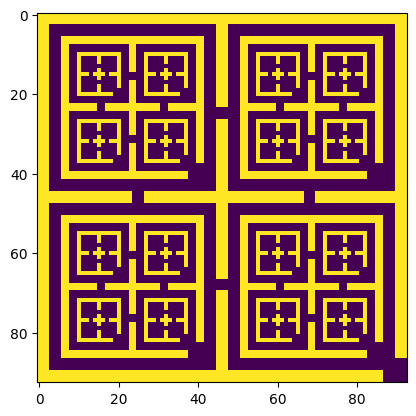

In [59]:
from utils import load_tree_model

In [67]:
np.array([1,2,3])[:,None]

array([[1],
       [2],
       [3]])

In [69]:
def generate_negative_samples(state, action, config):
    batch_size = state.shape[0]
    device = state.device

    # Create a range tensor for each item in the batch
    range_tensor = torch.arange(config.branching_factor + 2, device=device).unsqueeze(0).expand(batch_size, -1)

    # Create a mask to exclude the actual action for each item in the batch
    mask = range_tensor != action.unsqueeze(1)

    # Use the mask to select negative actions
    neg_actions = range_tensor[mask].view(batch_size, -1)

    # Repeat state for each negative action
    repeated_states = state.unsqueeze(1).expand(-1, config.branching_factor + 1, -1)

    # Combine repeated states with negative actions
    negative_full = torch.cat([repeated_states, neg_actions.unsqueeze(-1)], dim=-1)

    return negative_full

In [74]:
import torch

def generate_negative_samples(state, action, config):
    batch_size = state.shape[0]
    device = state.device

    # Create a range tensor for each item in the batch
    range_tensor = torch.arange(config.branching_factor + 2, device=device).unsqueeze(0).expand(batch_size, -1)

    # Create a mask to exclude the actual action for each item in the batch
    mask = range_tensor != action.unsqueeze(1)

    # Use the mask to select negative actions
    neg_actions = range_tensor[mask].view(batch_size, -1)

    # Repeat state for each negative action
    repeated_states = state.unsqueeze(1).expand(-1, config.branching_factor + 1)

    # Combine repeated states with negative actions
    negative_full = torch.stack([repeated_states, neg_actions], dim=-1)

    return negative_full

# Example usage:
batch_size = 3
config = type('Config', (), {'branching_factor': 3})()

# Example batched inputs (states are now integers)
state = torch.randint(0, 100, (batch_size,))  # Assuming states are integers from 0 to 99
action = torch.randint(0, config.branching_factor + 2, (batch_size,))

# Move tensors to the desired device (e.g., cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = state.to(device)
action = action.to(device)

# Generate negative samples
negative_full = generate_negative_samples(state, action, config)

print(f"State shape: {state.shape}")
print(f"Action shape: {action.shape}")
print(f"Negative samples shape: {negative_full.shape}")
print(f"Negative samples:\n{negative_full}")

State shape: torch.Size([3])
Action shape: torch.Size([3])
Negative samples shape: torch.Size([3, 4, 2])
Negative samples:
tensor([[[11,  0],
         [11,  1],
         [11,  2],
         [11,  4]],

        [[ 3,  0],
         [ 3,  1],
         [ 3,  2],
         [ 3,  4]],

        [[ 7,  0],
         [ 7,  1],
         [ 7,  2],
         [ 7,  3]]])


In [73]:
negative_full

tensor([[[ 0.1131, -2.6850,  0.0000],
         [ 0.1131, -2.6850,  2.0000],
         [ 0.1131, -2.6850,  3.0000],
         [ 0.1131, -2.6850,  4.0000]],

        [[-0.0903,  1.7367,  0.0000],
         [-0.0903,  1.7367,  1.0000],
         [-0.0903,  1.7367,  2.0000],
         [-0.0903,  1.7367,  4.0000]],

        [[ 0.4853,  1.0013,  1.0000],
         [ 0.4853,  1.0013,  2.0000],
         [ 0.4853,  1.0013,  3.0000],
         [ 0.4853,  1.0013,  4.0000]]])